<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/1-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->


In [1]:
# %matplotlib inline

# !pip install deeptrack

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.


## 1. Setup

Imports and defines the objects needed for this example.


In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt
from deeptrack.extras import datasets

import tensorflow as tf
import tensorflow_probability as tfp

# Download dataset from the cloud
datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")

VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


Dataset already downloaded.


## 2. Defining the dataset

### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.


In [3]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)[..., np.newaxis]

Since all training data is contained in a single file, we explicitly load the images


In [4]:
training_images = get_training_images.resolve()

We want to continuously generate new data for the network to train on. For this, we use the Dataset feature.


In [5]:
training_data_iterator = itertools.cycle(training_images)

training_iterator = dt.Dataset(
    data=training_data_iterator,
)

### 2.2 Augmenting the training set

In order to expand the dataset we augment it.


Affine augmentations consist of translating, rescaling, rotating and shearing


In [6]:
# How much to scale in x and y
scale = {
    "x": lambda: 0.8 + np.random.rand() * 0.4,
    "y": lambda: 0.8 + np.random.rand() * 0.4,
}

# How much to translate in x and y
translate_px = {
    "x": lambda: int(np.random.randint(-2, 3)),
    "y": lambda: int(np.random.randint(-2, 3)),
}

# Dummy property: whether to rotate or shear
should_rotate = lambda: np.random.randint(2)

# If should rotate, how much
rotate = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * should_rotate

# If not should rotate, how much shear
shear = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * (
    1 - should_rotate
)

affine_transform = dt.Affine(
    scale=scale,
    translate_px=translate_px,
    should_rotate=should_rotate,
    # shear=shear,
    order=2,
    mode="constant",
)

We also distort the images elastically.


In [7]:
elastic_transform = dt.ElasticTransformation(
    alpha=lambda: np.random.rand() * 60,  # Amplitude of distortions
    sigma=lambda: 5 + np.random.rand() * 2,  # Granularity of distortions
    ignore_last_dim=True,  # Last dimension is not a channel, so it should be augmented
    mode="constant",
)

Finally, since these distortions may cause pixels to fall outside the range of (0, 1), we normalize the images before feeding them to the network.


In [8]:
normalization = dt.NormalizeMinMax(0, 1)

We add the augmentations to the pipeline


In [9]:
augmentation = elastic_transform >> affine_transform >> normalization
augmented_training_set = training_iterator >> normalization

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.


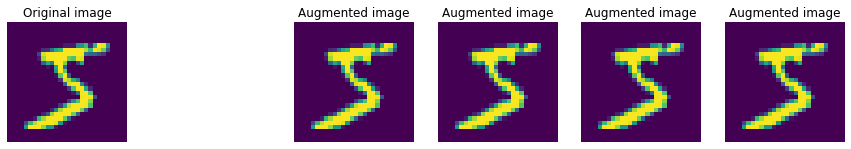

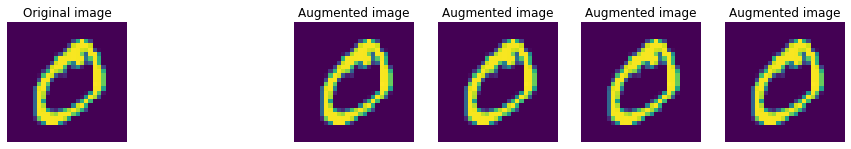

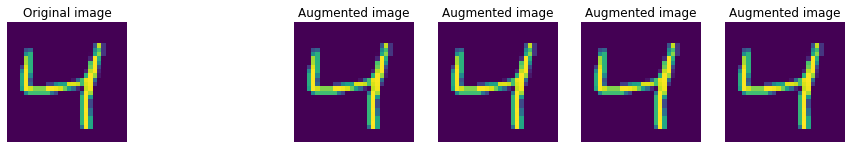

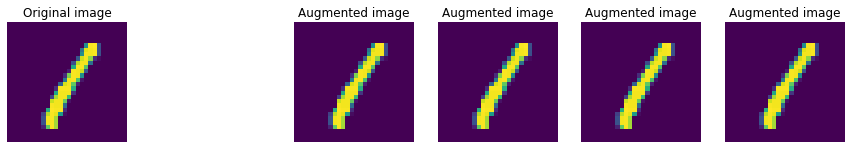

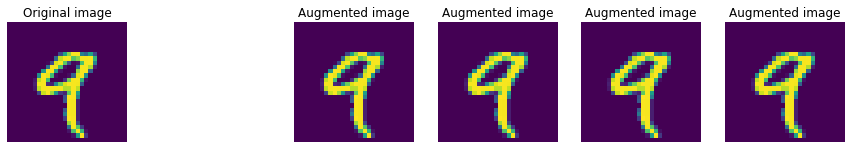

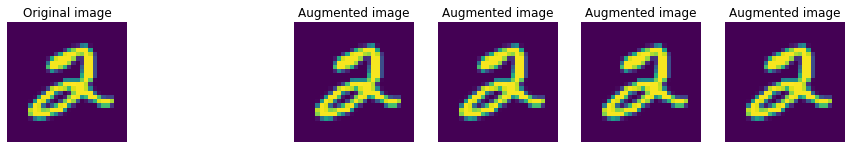

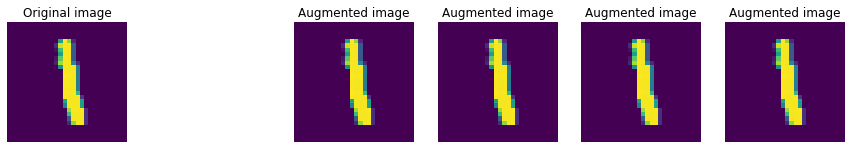

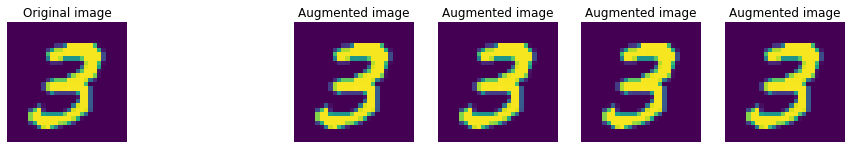

In [10]:
NUMBER_OF_IMAGES = 8

for image_index in range(NUMBER_OF_IMAGES):

    augmented_training_set.update()

    original_image = training_iterator()

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original image")

    for sub_plt in range(3, 7):
        # Only update the augmentation
        augmentation.update()
        augmented_image = augmented_training_set()
        plt.subplot(1, 6, sub_plt)
        plt.imshow(augmented_image)
        plt.axis("off")
        plt.title("Augmented image")

    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.


In [11]:
model = dt.models.VAE()


class binary_crossentropy(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(y_true, y_pred),
                axis=(1, 2),
            )
        )


model.compile(
    loss=binary_crossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.


Generating 1392 / 1000 samples before starting training
Epoch 1/100
15/15 [==============================] - 8s 562ms/step - loss: 301.2020 - reconstruction_loss: 299.1961 - kl_loss: 2.0060
Epoch 2/100
15/15 [==============================] - 11s 753ms/step - loss: 208.0926 - reconstruction_loss: 206.8439 - kl_loss: 1.2487
Epoch 3/100
15/15 [==============================] - 11s 750ms/step - loss: 197.3545 - reconstruction_loss: 195.1737 - kl_loss: 2.1809
Epoch 4/100
15/15 [==============================] - 11s 742ms/step - loss: 195.2491 - reconstruction_loss: 193.0438 - kl_loss: 2.2053
Epoch 5/100
15/15 [==============================] - 11s 756ms/step - loss: 183.0320 - reconstruction_loss: 180.5942 - kl_loss: 2.4378
Epoch 6/100
15/15 [==============================] - 11s 751ms/step - loss: 175.3891 - reconstruction_loss: 173.0235 - kl_loss: 2.3656
Epoch 7/100
15/15 [==============================] - 11s 747ms/step - loss: 171.9813 - reconstruction_loss: 169.5472 - kl_loss: 2.4340


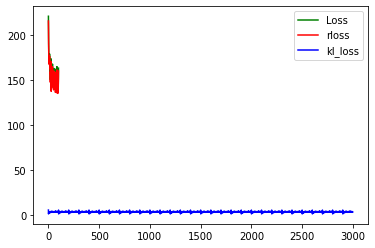

In [12]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        augmented_training_set & augmented_training_set,
        batch_size=64,
        min_data_size=1000,
        max_data_size=2000,
    )

    with generator:
        h = model.fit(generator, epochs=100)

    plt.plot(h.history["loss"], "g")
    plt.plot(h.history["reconstruction_loss"], "r")
    plt.plot(h.history["kl_loss"] * 30, "b")
    plt.legend(["Loss", "rloss", "kl_loss"])
    # plt.yscale("log")
    plt.show()

else:
    model_path = datasets.load_model("")
    model.load_weights(model_path)

## 5. Evaluating the network


### 5.1 Generate images from latent space


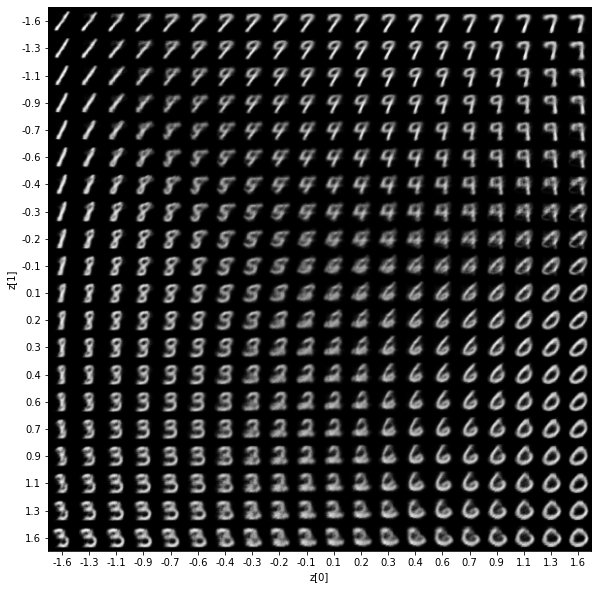

In [55]:
NUM_OF_IMAGES = 20
IMG_SIZE = 28

# Create a grid of latent space vectors
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, NUM_OF_IMAGES))
grid_y = norm.quantile(np.linspace(0.05, 0.95, NUM_OF_IMAGES))

image = np.zeros((28 * NUM_OF_IMAGES,) * 2)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create a latent space vector
        z = np.array([[xi, yi]])

        # Decode the vector
        gimg = model.decoder(z)

        image[
            i * IMG_SIZE : (i + 1) * IMG_SIZE,
            j * IMG_SIZE : (j + 1) * IMG_SIZE,
        ] = gimg.numpy()[..., 0]


plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")

start = IMG_SIZE // 2
end = NUM_OF_IMAGES * IMG_SIZE + start
pixel_range = np.arange(start, end, IMG_SIZE)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


### 5.2 Clustering images in latent space


In [66]:
# Load validation images and labels
get_validation_images = (
    dt.LoadImage(path=VALIDATION_SET_PATH)[..., np.newaxis] >> normalization
)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

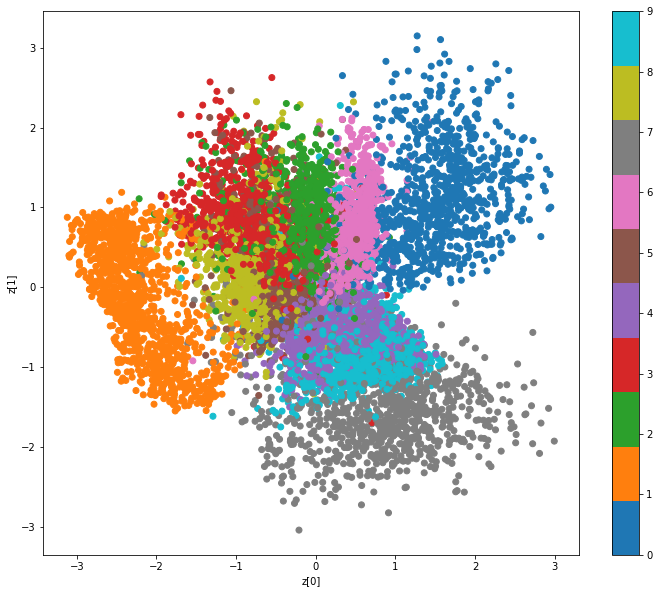

In [73]:
z_mean, _ = tf.split(
    model.encoder(validation_images._value), num_or_size_splits=2, axis=1
)

# plot latent space
plt.figure(figsize=(12, 10))
plt.scatter(
    z_mean[:, 0],
    z_mean[:, 1],
    c=validation_labels,
    cmap="tab10",
)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()
